In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import easydatascience as eds
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

original_data = pd.read_csv('appstore_games.csv').drop(['URL', 'Icon URL', 'Description'], axis=1)
data = original_data.loc[~original_data['Average User Rating'].isnull()]

data[['Subtitle', 'In-app Purchases']] = data[['Subtitle', 
                                               'In-app Purchases']].fillna('NA')
data['Languages'] = data['Languages'].fillna('EN')
data.columns = data.columns.str.replace(' ', '_')
data.Age_Rating = data.Age_Rating.str.replace('+', '').astype('int32')

data['Size_MB'] = round(data['Size']/1024**2, 3)
data = data.drop('Size', axis=1)

#eds.look(data).sort_values(by='nulls', ascending=False)

In [140]:
#Instance frequency within these attributes was examined
data['Has_Subtitle'] = np.where(data['Subtitle']=='NA', 0, 1)
data['Free_to_Play'] = np.where(data['Price']==0, 1, 0)
data['In-app_Purchases'] = np.where(data['In-app_Purchases']=='NA', 0, 1)
data['Multilingual'] = np.where(data['Languages']=='EN', 0, 1)
data = data.drop(['Subtitle', 'Primary_Genre', 'Price', 'Languages'], axis=1)

data['Original_Release_Date'] = data['Original_Release_Date'].str.replace('/', '-')
data['Current_Version_Release_Date'] = data['Current_Version_Release_Date'].str.replace('/', '-')

data['Release_Year'] = pd.to_datetime(data['Original_Release_Date']).dt.year
data['Release_Month'] = pd.to_datetime(data['Original_Release_Date']).dt.month
data['Days_Since_Last_Update'] = (pd.Timestamp.now().date() - pd.to_datetime(
            data['Current_Version_Release_Date']).dt.date).astype('timedelta64[D]')

data = data.drop(['Original_Release_Date', 'Current_Version_Release_Date'], axis=1)

#names = pd.read_csv('usafirstnames.csv')['Names'].str.lower().values.tolist()
#names = '|'.join(names)
#data['Developer'] = data['Developer'].str.lower()
#data['Indie'] = np.where(data['Developer'].str.contains(names), 1, 0)
data = data.drop('Developer', axis=1)

data = eds.one_hot_encode(data, 'Genres')
data = eds.degrade_columns(data, ', ', filter=True)

In [141]:
from sklearn.preprocessing import KBinsDiscretizer

kbdisc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

corr_drop_list = eds.get_abv_corr(data, data['Average_User_Rating'], threshold=0.03)
num_data = data.drop(corr_drop_list, axis=1)

#eds.plot_spread(num_data, ['User_Rating_Count', 'Size_MB'])
num_data[['User_Rating_Count', 'Size_MB']] = kbdisc.fit_transform(num_data[['User_Rating_Count', 
                                                                            'Size_MB']])

#eds.look(train, pred='Average_User_Rating').sort_values(by='corrAverage_User_Rating',
#                                                        ascending=False)

In [142]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(num_data, test_size=0.3, random_state=13)

test_IDN = test[['ID', 'Name']]
test = test.drop(['ID', 'Name'], axis=1)
X_test, y_test = test.drop('Average_User_Rating', axis=1), test['Average_User_Rating']

#Outliers if there are some...

train_IDN = train[['ID', 'Name']]
train = train.drop(['ID', 'Name'], axis=1)
X_train, y_train = train.drop('Average_User_Rating', axis=1), train['Average_User_Rating']

R2 score:  0.25159002649250417
RMSE:  0.6520850038676677
Cross-Validation: 
	Scores: [0.69491947 0.66223936 0.70677167 0.6573875 ]
	Mean: 0.6803294984574422
	Standard deviation: 0.021009781238676327


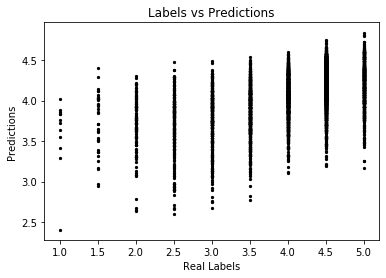

In [143]:
#eds.print_abv_ft_corr(X_train, 0.45)
import xgboost
from sklearn.linear_model import LinearRegression

xgb_reg = eds.simple_reg_model(xgboost.XGBRegressor(objective ='reg:squarederror'),
                               X_train, y_train, return_model=True)

In [144]:
#COMUNICATING INSIGHTS

"""
As we see, predictions don't look very good, even if we don't drop statistically insignificant
features and leave the feature space at ~100 attributes, it still fails even to overfit. From 
this, we can deduce that features are not good enough and we need more of them to make a
prediction model (like the number of downloads, downloads in first few days, reported bugs, 
how much did app show up on people's main page, did it get to top list, etc.).
Still, that doesn't prevent us to do descriptive analytics on the features we have.
"""

"\nAs we see, predictions don't look very good, even if we don't drop statistically insignificant\nfeatures and leave the feature space at ~100 attributes, it still fails even to overfit. From \nthis, we can deduce that features are not good enough and we need more of them to make a\nprediction model (like the number of downloads, downloads in first few days, reported bugs, \nhow much did app show up on people's main page, did it get to top list, etc.).\nStill, that doesn't prevent us to do descriptive analytics on the features we have.\n"

In [145]:
eds.look(a_data, 'Average_User_Rating').sort_values(by='corrAverage_User_Rating', ascending=False)

___________________________
Data types:
 int64      11
int32       5
float64     4
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ratio,uniques,skewness,corrAverage_User_Rating
Average_User_Rating,float64,7561,9,0,0.0,"[[4.0, 3.5, 3.0, 2.5, 2.0, 4.5, 1.5, 5.0, 1.0]]",-1.157873,1.000000
Release_Year,int64,7561,12,0,0.0,"[[2008.0, 2009.0, 2016.0, 2010.0, 2011.0, 2014...",-0.359626,0.231705
Has_Subtitle,int32,7561,2,0,0.0,"[[0.0, 1.0]]",0.582229,0.185376
In-app_Purchases,int32,7561,2,0,0.0,"[[0.0, 1.0]]",-0.463586,0.151692
Size_MB,float64,7561,7307,0,0.0,"[[15.119, 11.758, 0.644, 20.554, 33.082, 46.41...",6.408662,0.061617
Casual,int64,7561,2,0,0.0,"[[0.0, 1.0]]",3.380341,0.052122
Puzzle,int64,7561,2,0,0.0,"[[1.0, 0.0]]",1.658021,0.046951
Multilingual,int32,7561,2,0,0.0,"[[1.0, 0.0]]",0.701152,0.037830
User_Rating_Count,float64,7561,1792,0,0.0,"[[3553.0, 284.0, 8376.0, 190394.0, 28.0, 47.0,...",53.711639,0.033025
Free_to_Play,int32,7561,2,0,0.0,"[[0.0, 1.0]]",-1.820452,0.031072


Average_User_Rating 1.0
Release_Year 0.23170514868232348
Days_Since_Last_Update -0.24744394567392528

These are features that correlate the best with the target.
Still not exceptional, but good enough to give us some intuition.


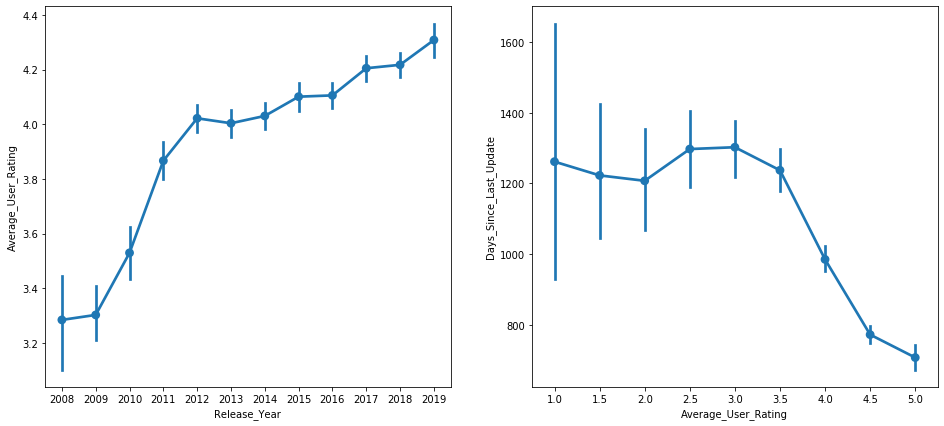

In [146]:
a_data = data.drop(['ID', 'Name'], axis=1)
eds.print_abv_corr(a_data, a_data['Average_User_Rating'], threshold=0.2)

print('\nThese are features that correlate the best with the target.\nStill not exceptional, but good enough to give us some intuition.')

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

sns.catplot(x='Release_Year', y='Average_User_Rating', data=a_data, kind='point', ax=ax[0])
sns.catplot(x='Average_User_Rating', y='Days_Since_Last_Update', data=a_data, kind='point', 
                                                                                  ax=ax[1])
plt.close()
plt.close()

The only other statistically significant value is Size_MB, but with only 0.06
correlation which, given stretched confidence intervals, isn't of much use.


Text(0.5, 1, 'Point plot with app size in MB')

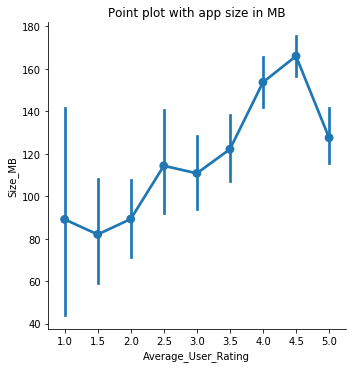

In [147]:
print("The only other statistically significant value is Size_MB, but with only 0.06\ncorrelation which, given stretched confidence intervals, isn't of much use.")

sns.catplot(x='Average_User_Rating', y='Size_MB', data=a_data, kind='point')
plt.title('Point plot with app size in MB')

In [148]:
print('We may argue that the genre affects the rating of the app but that is not the case.\nWe can see that most of those features are statistically irrelevant.')
print('\nCorrelation of genres with average user rating:\n')
print(a_data[['Casual', 'Puzzle', 'Action', 'Role Playing', 'Card', 'Adventure', 'Simulation',
        'Board', 'Entertainment']].corrwith(a_data['Average_User_Rating']))

print('\nAlso, we might assume that features like age rating, number of ratings or the fact that the game if\nfree to play but again, that is not the case.')
print('\nCorrelation of Age_Rating, User_Rating_Count and Free_to_Play with the target:\n')
print(a_data[['Age_Rating', 'User_Rating_Count', 
              'Free_to_Play']].corrwith(a_data['Average_User_Rating']))

print('\nOn the other hand, subtitles and included in-app purchases seem to be important for overall user satisfaction.')
print('\nCorrelation of Has_Subtitle and In-app_Purchases with the target:\n')
print(a_data[['Has_Subtitle', 'In-app_Purchases']].corrwith(a_data['Average_User_Rating']))

We may argue that the genre affects the rating of the app but that is not the case.
We can see that most of those features are statistically irrelevant.

Correlation of genres with average user rating:

Casual           0.052122
Puzzle           0.046951
Action           0.024461
Role Playing     0.016357
Card            -0.002746
Adventure       -0.011440
Simulation      -0.043359
Board           -0.086449
Entertainment   -0.037803
dtype: float64

Also, we might assume that features like age rating, number of ratings or the fact that the game if
free to play but again, that is not the case.

Correlation of Age_Rating, User_Rating_Count and Free_to_Play with the target:

Age_Rating           0.020307
User_Rating_Count    0.033025
Free_to_Play         0.031072
dtype: float64

On the other hand, subtitles and included in-app purchases seem to be important for overall user satisfaction.

Correlation of Has_Subtitle and In-app_Purchases with the target:

Has_Subtitle        0.185376
In-app

__In the end, the average user rating can be a very biased metric of success since, for
example, most of the apps these days force users to give a 5-star rating for them to get something in return. This is just one of many examples but still, it is one of the better examples of user satisfaction. The best success metric of how well the app is doing is revenue,
which was not examinable in this data set.__